In [79]:
import numpy as np
import random as rd # To randomize the dataset over each epoch
import time # To monitor the computation time, and compare SGD with and without minibatching
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [80]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

print(len(x_train))

60000


label is 1


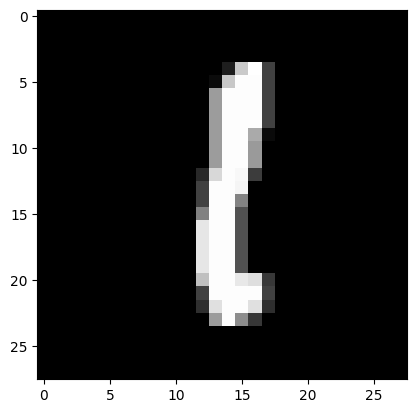

In [81]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [82]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digits (InputLayer)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([0, 0, 0, 0, 8, 3, 0, 0, 8, 9, 8, 5, 0, 3, 3, 3, 5, 0, 3, 0, 0, 7,
       3, 5, 7, 0, 3, 3, 0, 5], dtype=int64)

In [84]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities. 

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [85]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
    
        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [86]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()
    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]
    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [87]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3302045

# 4. Training the model

In [ ]:
"""
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ digits (InputLayer)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
"""

# Question 4.1 :
The output shape required for the computation of the number of parameters is shown just above.

Since we have 784 nodes (or neurons) in the first 'Input layer', and 32 in the following dense_1 layer, the number of parameters required by the neural network computation to go from the first to the second layer is calculated as following :

We have for the first layer 784 nodes, and 32 nodes for the second. Since there is one parameter for each node from the first layer to each node of the second layer, plus one more constant parameter from the perceptron for the linear computation of the probability function $\phi_\theta$, there is a total of $\underline{(784 + 1)*32 = 25120 }$ $\mathbf{parameters}$ to train required by the neural network to go from the first layer to the second one.

We do the same computation to go from the dense_1 layer with 32 nodes, to the dense_2 layer with 32 nodes, and we get $\underline{(32 + 1)*32 = 1056 }$ $\mathbf{parameters}$
Again to go from the dense_2 layer with 32 nodes, to the predictions (output) layer with 10 nodes, and we get $\underline{(32 + 1)*10 = 330 }$ $\mathbf{parameters}$

We get a total of  $\underline{25120 + 1056 + 330 = 26506 }$ optimization variables to train
___

In [70]:
# Stochastic gradient algorithm

def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1, display = False):
    L_mean_loss = []
    cpt = -1 # We want to see the mean loss error after the first iteration
    for epoch in range(epochs):
        indices = np.arange(len(x_train)) # We randomize indices to get a different order for the dataset
        rd.shuffle(indices)
        x_train_copy_shuffle = x_train.copy()[indices]
        y_train_copy_shuffle = y_train.copy()[indices]
        for i in range(len(x_train)//batch_size): # We go over all the data samples
            cpt+=1
            x_train_batch = x_train_copy_shuffle[i*batch_size:(i+1)*batch_size]
            y_train_batch = y_train_copy_shuffle[i*batch_size:(i+1)*batch_size]
            with tf.GradientTape() as tape:
                predicted_logits = model(x_train_batch)  # Predicted logits for this minibatch
                loss_value = loss(y_train_batch, predicted_logits) # Compute the loss value for this minibatch.
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, grad, -learning_rate/np.sqrt((epoch+1)*len(x_train)))
            if cpt % 500 == 0:
                m = mean_loss(model, x_train_batch, y_train_batch)
                L_mean_loss.append(m)
                if display:
                    print(f'Iteration {cpt} / Mean loss : {m:.5f}') # {m:.5f} allows to round the mean loss to its 5th decimal
    return(L_mean_loss)

The display parameter used in the Stochastic Gradient Descent is to print the mean loss error at each iteration.

The test functions below are functions used to test the model, and see how well it handles the training data sample once the model has been trained, and how well it handles the test data sample, which is data that is yet unknown to the model.

In [88]:
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

def test_function_training_set(model):
    cpt = 0
    logits = model(x_train)
    y_pred = np.argmax(logits, 1)
    for i in range(len(x_train)):
        if y_pred[i] == y_train[i]:
            cpt +=1
    return(100*cpt/len(x_train)) # Return the accuracy as a percentage

def test_function_test_set(model):
    cpt = 0
    logits = model(x_test)
    y_pred = np.argmax(logits, 1)
    for i in range(len(x_test)):
        if y_pred[i] == y_test[i]:
            cpt +=1
    return(100*cpt/len(x_test))


Average mean loss for the training set, using the trained basic model : 0.44008

For the training set, the trained model is accurate for 97.518 % of the data

For the test set, the trained model is accurate for 96.480 % of the data


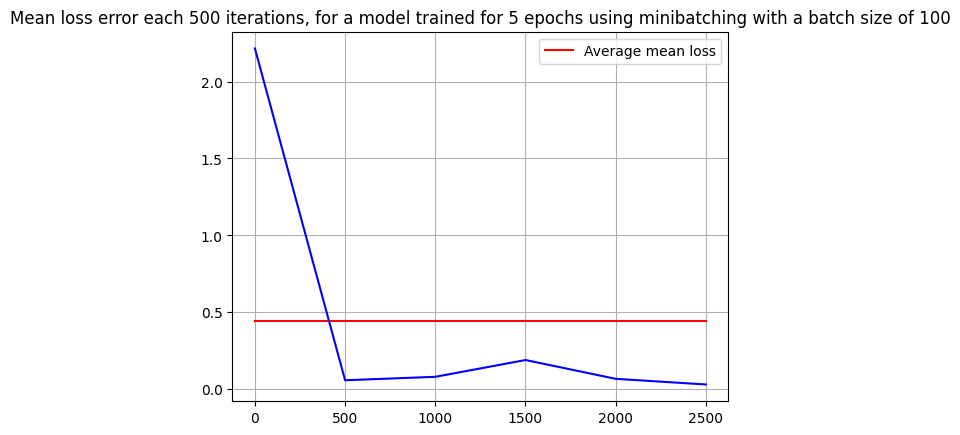

In [113]:
# Initialize model
model = build_model()
L_mean_loss = SGD(model, x_train, y_train, 1, 5, 100, display = False) # Train the model and compute the mean loss

aml = sum(L_mean_loss)/len(L_mean_loss) # Average Mean Loss

plt.plot([0,500*(len(L_mean_loss)-1)],[aml,aml],label="Average mean loss",color='red')
plt.plot([500*i for i in range(len(L_mean_loss))], L_mean_loss, color = 'blue')
plt.title("Mean loss error each 500 iterations, for a model trained for 5 epochs using minibatching with a batch size of 100")
plt.legend()
plt.grid()

print(f"\nAverage mean loss for the training set, using the trained basic model : {sum(L_mean_loss)/len(L_mean_loss):.5f}")
print(f"\nFor the training set, the trained model is accurate for {test_function_training_set(model):.3f} % of the data")
print(f"\nFor the test set, the trained model is accurate for {test_function_test_set(model):.3f} % of the data")

# Question 5.2 :

The block of code above is the main one. It will be used to display the final parameters chosen to optimize the computation as well as the results (percentage of errors).

The blocks of code below are run only once to prevent long time of computations. The only differences are the parameters that are being adjusted to answer the different questions. For example, the number of epochs, the batch size, the step size choice.
___

The basic model (1 epoch, no minibatching) computation uses a step size that satisfies the condition required by theory.
We would like $\sum_{j=1}^{k} \gamma_j \to +\infty$  and  $\frac{\sum_{l=1}^{k} \gamma_l^2}{\sum_{j=1}^{k} \gamma_j} \to 0$

A step size satisfying such condition has the form : $\gamma_k = \frac{\gamma_0}{(k+1)^\alpha}$  with  $0 < \alpha < 1$

For optimality, we choose $\alpha = \frac{1}{2}$ and $\gamma_0 = \frac{1}{\sqrt{n}}$ with $n$ being the size of our dataset

$\gamma_k = \frac{1}{\sqrt{n(k+1)}}$, with $k$ being the $k^{th}$ epoch (iteration over the dataset) 


Iteration 0 / Mean loss : 2.26718
Iteration 500 / Mean loss : 1.70748
Iteration 1000 / Mean loss : 0.19976
Iteration 1500 / Mean loss : 0.08598
Iteration 2000 / Mean loss : 0.59216
Iteration 2500 / Mean loss : 0.23079
Iteration 3000 / Mean loss : 0.16862
Iteration 3500 / Mean loss : 0.08786
Iteration 4000 / Mean loss : 0.00147
Iteration 4500 / Mean loss : 0.00989
Iteration 5000 / Mean loss : 0.05790
Iteration 5500 / Mean loss : 0.04660
Iteration 6000 / Mean loss : 0.01767
Iteration 6500 / Mean loss : 0.06461
Iteration 7000 / Mean loss : 0.04008
Iteration 7500 / Mean loss : 0.11838
Iteration 8000 / Mean loss : 0.13288
Iteration 8500 / Mean loss : 0.00571
Iteration 9000 / Mean loss : 0.05806
Iteration 9500 / Mean loss : 0.00648
Iteration 10000 / Mean loss : 0.11160
Iteration 10500 / Mean loss : 0.00223
Iteration 11000 / Mean loss : 0.35180
Iteration 11500 / Mean loss : 0.00039
Iteration 12000 / Mean loss : 0.00485
Iteration 12500 / Mean loss : 0.02455
Iteration 13000 / Mean loss : 0.2708

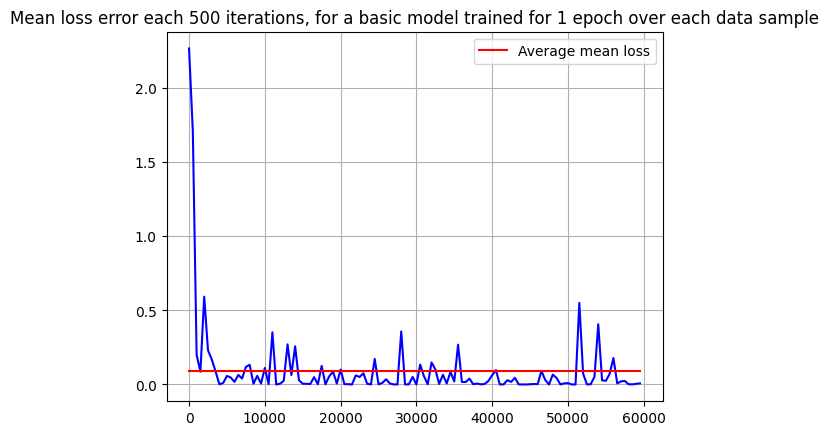

In [76]:
# Initialize model for 1 epoch and a batch size of 1

basic_model = build_model()
basic_L_mean_loss = SGD(basic_model, x_train, y_train, 1, display = True) # Train the model and compute the mean loss

amlb = sum(basic_L_mean_loss)/len(basic_L_mean_loss) # Average Mean Loss Basic

plt.plot([500*i for i in range(len(basic_L_mean_loss))], basic_L_mean_loss, color = 'blue')
plt.plot([0,500*(len(basic_L_mean_loss)-1)],[amlb,amlb],label="Average mean loss",color='red')
plt.title("Mean loss error each 500 iterations, for a basic model trained for 1 epoch over each data sample")
plt.legend()
plt.grid()

print(f"\nAverage mean loss for the training set, using the trained basic model : {amlb:.5f}")
print(f"\nFor the training set, the trained basic model is accurate for {test_function_training_set(basic_model):.4f} % of the data")
print(f"\nFor the test set, the trained basic model is accurate for {test_function_test_set(basic_model):.4f} % of the data")

For this basic model (question 5.2, single epoch and no minibatching), we compute it only a single time with a single step size, since the computation is costly and takes too much time.

___

## Computing the basic SGD for multiple epochs (without minibatching) :

Iteration 0 / Mean loss : 2.02108
Iteration 500 / Mean loss : 1.08793
Iteration 1000 / Mean loss : 0.60029
Iteration 1500 / Mean loss : 0.68822
Iteration 2000 / Mean loss : 0.04492
Iteration 2500 / Mean loss : 0.08854
Iteration 3000 / Mean loss : 0.20997
Iteration 3500 / Mean loss : 0.08921
Iteration 4000 / Mean loss : 0.48086
Iteration 4500 / Mean loss : 0.04630
Iteration 5000 / Mean loss : 0.81200
Iteration 5500 / Mean loss : 0.11942
Iteration 6000 / Mean loss : 0.00547
Iteration 6500 / Mean loss : 0.01857
Iteration 7000 / Mean loss : 0.12603
Iteration 7500 / Mean loss : 0.01885
Iteration 8000 / Mean loss : 0.12000
Iteration 8500 / Mean loss : 0.00141
Iteration 9000 / Mean loss : 0.16209
Iteration 9500 / Mean loss : 0.00706
Iteration 10000 / Mean loss : 0.28536
Iteration 10500 / Mean loss : 0.00408
Iteration 11000 / Mean loss : 1.27852
Iteration 11500 / Mean loss : 0.00066
Iteration 12000 / Mean loss : 0.10371
Iteration 12500 / Mean loss : 0.00504
Iteration 13000 / Mean loss : 0.0052

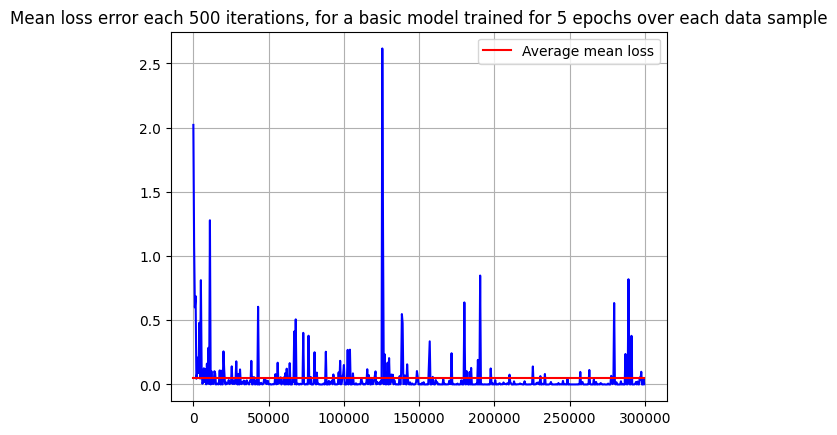

In [78]:
# Initialize model for 5 epoch and a batch size of 1

basic_5_epochs_model = build_model()
basic_5_epochs_L_mean_loss = SGD(basic_5_epochs_model, x_train, y_train, 1, epochs = 5, display = True)

amlb5e = sum(basic_5_epochs_L_mean_loss)/len(basic_5_epochs_L_mean_loss) # Average Mean Loss Basic 5 epochs

plt.plot([500*i for i in range(len(basic_5_epochs_L_mean_loss))], basic_5_epochs_L_mean_loss, color = 'blue')
plt.plot([0,500*(len(basic_5_epochs_L_mean_loss)-1)],[amlb5e,amlb5e],label="Average mean loss",color='red')
plt.legend()
plt.title("Mean loss error each 500 iterations, for a basic model trained for 5 epochs over each data sample")
plt.grid()

print(f"\nAverage mean loss for the training set, using the trained basic model with 5 epochs : {amlb5e:.5f}")
print(f"\nFor the training set, the trained basic model for 5 epochs is accurate for {test_function_training_set(basic_5_epochs_model):.3f} % of the data")
print(f"\nFor the test set, the trained basic model for 5 epochs is accurate for {test_function_test_set(basic_5_epochs_model):.3f} % of the data")

# Question 6.1 :

By using multiple epochs, we get a slightly better result on the training set and the test set.

By using 5 epochs (iterations over the dataset) :
For the training set, the accuracy is 97.778 %
For the test set, the accuracy is 96.870 %

By computing a single epoch :
For the training set, the accuracy is 95.2100 %
For the test set, the accuracy is 95.1400 %

However, because of the costly calculations required by each epoch, it doesn't seem better to use multiple epochs for such similar results.
___ 

We see that without minibatching, the computation time required is huge.

# Question 6.2 :

Minibatching allows using multiple data sample to compute a single step to update the parameters of our model, thus saving computation time by reducing the number of iterations to go over all the data samples on a single epoch.

In our case, with a training data set of 60'000 samples, by using a batch size of 30, we reduce the number of iterations per epoch from 60'000 to 2'000.
___ 

# Question 6.3 :

We will try different batch size to see how the accuracy and the computation time change. We take as reference the value of basic model without minibatching. 

In [107]:
# Initialize model without minibatching, reference time :
reference_model = build_model()

start = time.time()
L_reference_mean_loss = SGD(reference_model, x_train, y_train, 1, 1, 1, display = False)
reference_time = time.time() - start

reference_aml = sum(L_mean_loss)/len(L_mean_loss) # Average Mean Loss
reference_training_set_accuracy = test_function_training_set(reference_model)
reference_test_set_accuracy = test_function_test_set(reference_model)

computation_times = []
average_mean_losses = []
training_set_accuracies = []
test_set_accuracies = []

batchsizes = [5,10,20,30,50,100,200,300,500]
for batch_size in batchsizes :
    model = build_model()
    start=time.time()
    L_mean_loss = SGD(model, x_train, y_train, 1, 1, batch_size=batch_size, display = False)
    computation_times.append((time.time()-start)/reference_time)
    average_mean_losses.append(sum(L_mean_loss)/len(L_mean_loss))
    training_set_accuracies.append(test_function_training_set(model))
    test_set_accuracies.append(test_function_test_set(model))

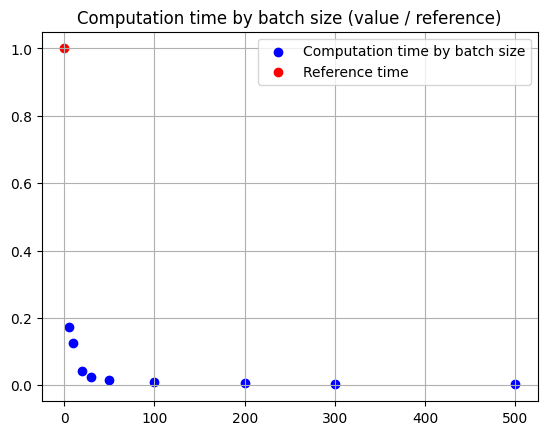

In [108]:
plt.scatter(batchsizes,computation_times,label="Computation time by batch size",color='blue')
plt.scatter([0], [1], label="Reference time", color = 'red')
plt.title("Computation time by batch size (value / reference)")
plt.legend()
plt.grid()

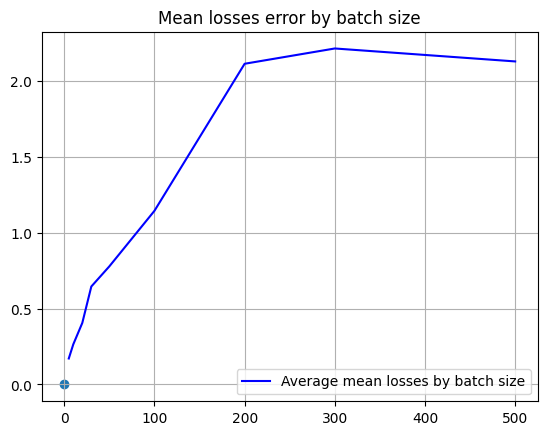

In [109]:
plt.plot(batchsizes,average_mean_losses,label="Average mean losses by batch size",color='blue')
plt.scatter([0],[0])
plt.title("Mean losses error by batch size")
plt.legend()
plt.grid()

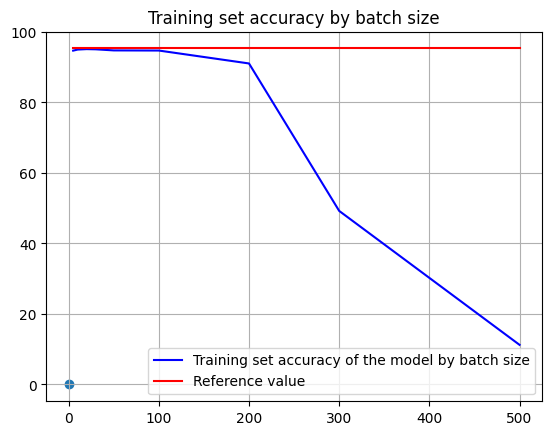

In [110]:
plt.plot(batchsizes,training_set_accuracies,label="Training set accuracy of the model by batch size",color='blue')
plt.plot([batchsizes[0],batchsizes[-1]], [reference_training_set_accuracy,reference_training_set_accuracy], label="Reference value", color = 'red')
plt.scatter([0],[0])
plt.title("Training set accuracy by batch size")
plt.legend()
plt.grid()

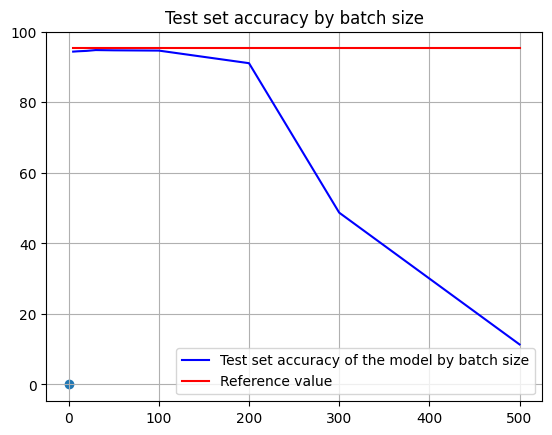

In [111]:
plt.plot(batchsizes,test_set_accuracies,label="Test set accuracy of the model by batch size",color='blue')
plt.plot([batchsizes[0],batchsizes[-1]], [reference_test_set_accuracy,reference_test_set_accuracy], label="Reference value", color = 'red')
plt.scatter([0],[0])
plt.title("Test set accuracy by batch size")
plt.legend()
plt.grid()

# Question 7.1 :

We see that $\underline{\text{the optimal value for our batch size is 100}}$ : we keep an accuracy as good as the reference value, and the computation time is reduced drastically.

After this point, for batch sizes of 200, 300, and 500 at last, the accuracy is decreasing until it reaches 10% (which at this point is the same as random guesses) for the batch size of 500.

The computation time follows the inverse function of batch size : we need to chose a high batch size to reduce computation time, but we still want to keep a high accuracy, thus the choice of batch size being 100.